* http://www.bio.ic.ac.uk/research/crawley/statistics/
  * http://www.bio.ic.ac.uk/research/crawley/statistics/data.htm
    * http://www.bio.ic.ac.uk/research/crawley/statistics/data/zipped.zip
      * t.test.data.csv
      * light.csv

In [1]:
ENV["LINES"], ENV["COLUMNS"] = 100, 100
using Base.Threads
using BenchmarkTools
using DataFrames
using Distributions
using LinearAlgebra
using Memoization
using Printf
using QuadGK
using RCall
using Random
Random.seed!(4649373)
using Roots
using SpecialFunctions
using StaticArrays
using StatsBase
using StatsFuns
using StatsPlots
default(fmt = :png, size = (400, 250),
    titlefontsize = 10, plot_titlefontsize = 12)
using SymPy

In [2]:
using DataFrames

# t.test.data.csv
data = [
    3 5
    4 5
    4 6
    3 7
    2 4
    3 4
    1 3
    3 5
    5 6
    2 5
]
gardenA = data[:,1]
gardenB = data[:,2]
df = DataFrame(; gardenA, gardenB)

Row,gardenA,gardenB
,Int64,Int64
1,3,5
2,4,5
3,4,6
4,3,7
5,2,4
6,3,4
7,1,3
8,3,5
9,5,6


In [3]:
@show mean(gardenA) mean(gardenB)
@show var(gardenA) var(gardenB);

mean(gardenA) = 3.0
mean(gardenB) = 5.0
var(gardenA) = 1.3333333333333333
var(gardenB) = 1.3333333333333333


In [4]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [5]:
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [6]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [7]:
s²_student(m, sx², n, sy²) = ((m-1)*sx² + (n-1)*sy²)/(m+n-2)

function tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    s² = s²_student(m, sx², n, sy²)
    (x̄ - ȳ - Δμ) / √(s²*(1/m + 1/n))
end

function tvalue_student(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function pvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
    2ccdf(TDist(m+n-2), abs(t))
end

function pvalue_student(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_student(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_student(m, x̄, sx², n, ȳ, sy²; α=0.05)
    c = quantile(TDist(m+n-2), 1-α/2)
    s² = s²_student(m, sx², n, sy²)
    SEhat = √(s²*(1/m + 1/n))
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_student(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_student(m, x̄, sx², n, ȳ, sy²; α)
end

confint_student (generic function with 2 methods)

In [8]:
@show pvalue_welch(gardenA, gardenB)
@show pvalue_student(gardenA, gardenB);

pvalue_welch(gardenA, gardenB) = 0.0011145389906555528
pvalue_student(gardenA, gardenB) = 0.0011145389906555528


In [9]:
Random.seed!(4649373)
gardenC = rand(1:12, 20)
@show gardenB mean(gardenB) var(gardenB)
@show gardenC mean(gardenC) var(gardenC);

gardenB = [5, 5, 6, 7, 4, 4, 3, 5, 6, 5]
mean(gardenB) = 5.0
var(gardenB) = 1.3333333333333333
gardenC = [7, 2, 1, 9, 11, 6, 7, 9, 9, 10, 7, 1, 6, 3, 5, 9, 6, 9, 7, 11]
mean(gardenC) = 6.75
var(gardenC) = 9.460526315789474


In [10]:
@show degree_of_freedom_welch(10, 1.33, 10, 1.33)
@show degree_of_freedom_welch(10, 1.33, 20, 9.46);

degree_of_freedom_welch(10, 1.33, 10, 1.33) = 18.0
degree_of_freedom_welch(10, 1.33, 20, 9.46) = 26.726236906571703


In [11]:
@show pvalue_welch(gardenB, gardenC)
@show pvalue_student(gardenB, gardenC);

pvalue_welch(gardenB, gardenC) = 0.03307647050499271
pvalue_student(gardenB, gardenC) = 0.09525010432228377


In [12]:
gardenD = Float64[gardenB; gardenB]
gardenD[4] += 0.310445
var(gardenD)

1.3333335417433556

In [13]:
@show degree_of_freedom_welch(10, 1.33, 10, 1.33);
@show degree_of_freedom_welch(10, 1.33, 20, 1.33);

degree_of_freedom_welch(10, 1.33, 10, 1.33) = 18.0
degree_of_freedom_welch(10, 1.33, 20, 1.33) = 18.105882352941173


In [14]:
@show pvalue_welch(gardenB, gardenD)
@show pvalue_student(gardenB, gardenD);

pvalue_welch(gardenB, gardenD) = 0.9726917314581186
pvalue_student(gardenB, gardenD) = 0.97255819945055


speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]
median(speed) = 940.0
mean(speed) = 909.0
var(speed) = 11009.473684210527
skewness(speed) = -0.8906989686637442
kurtosis(speed) = 0.15387338159088726
pvalue_tdist(speed, 990) = 0.0026685840985367784
pvalue(SignedRankTest(speed .- 990)) = 0.0021301280771450506


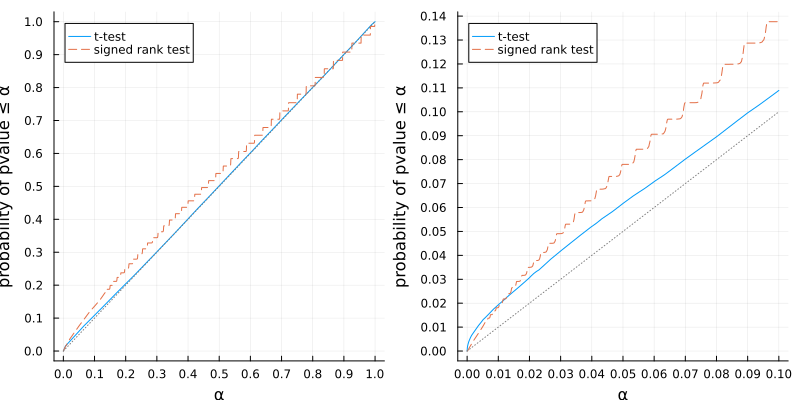

In [15]:
using HypothesisTests
using Distributions
using StatsBase: ecdf
using StatsPlots

function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

# light.csv
speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]

@show speed
@show median(speed) mean(speed) var(speed) skewness(speed) kurtosis(speed)
@show pvalue_tdist(speed, 990)
@show pvalue(SignedRankTest(speed .- 990))

pval_t, pval_w = let L = 10^5, c = 0, n = length(speed)
    pval_t = Vector{Float64}(undef, L)
    pval_w = Vector{Float64}(undef, L)
    for i in 1:L
        X = sample(speed, n)
        pval_t[i] = pvalue_tdist(X, mean(speed))
        pval_w[i] = pvalue(SignedRankTest(X .- mean(speed)))
    end
    pval_t, pval_w
end
_ecdf_pval_t = ecdf(pval_t)
_ecdf_pval_w = ecdf(pval_w)
ecdf_pval_t(x) = _ecdf_pval_t(x)
ecdf_pval_w(x) = _ecdf_pval_w(x)

P1 = plot(ecdf_pval_t, 0, 1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

P2 = plot(ecdf_pval_t, 0, 0.1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

plot(P1, P2; size=(800, 400))

speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]
median(speed) = 940.0
mean(speed) = 909.0
var(speed) = 11009.473684210527
skewness(speed) = -0.8906989686637442
kurtosis(speed) = 0.15387338159088726
pvalue_tdist(speed, 990) = 0.0026685840985367784
pvalue(SignedRankTest(speed .- 990)) = 0.0021301280771450506


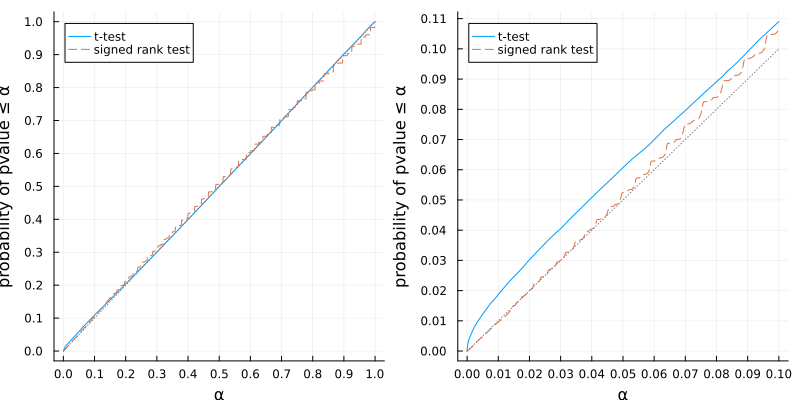

In [16]:
using HypothesisTests
using Distributions
using StatsBase: ecdf
using StatsPlots

function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

# light.csv
speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]

@show speed
@show median(speed) mean(speed) var(speed) skewness(speed) kurtosis(speed)
@show pvalue_tdist(speed, 990)
@show pvalue(SignedRankTest(speed .- 990))

pval_t, pval_w = let L = 10^5, c = 0, n = length(speed)
    pval_t = Vector{Float64}(undef, L)
    pval_w = Vector{Float64}(undef, L)
    for i in 1:L
        X = sample(speed, n)
        pval_t[i] = pvalue_tdist(X, mean(speed))
        pval_w[i] = pvalue(SignedRankTest(X .- 920))
    end
    pval_t, pval_w
end
_ecdf_pval_t = ecdf(pval_t)
_ecdf_pval_w = ecdf(pval_w)
ecdf_pval_t(x) = _ecdf_pval_t(x)
ecdf_pval_w(x) = _ecdf_pval_w(x)

P1 = plot(ecdf_pval_t, 0, 1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

P2 = plot(ecdf_pval_t, 0, 0.1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

plot(P1, P2; size=(800, 400))

speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]
median(speed) = 940.0
mean(speed) = 909.0
var(speed) = 11009.473684210527
skewness(speed) = -0.8906989686637442
kurtosis(speed) = 0.15387338159088726
pvalue_tdist(speed, 990) = 0.0026685840985367784
pvalue(SignedRankTest(speed .- 990)) = 0.0021301280771450506


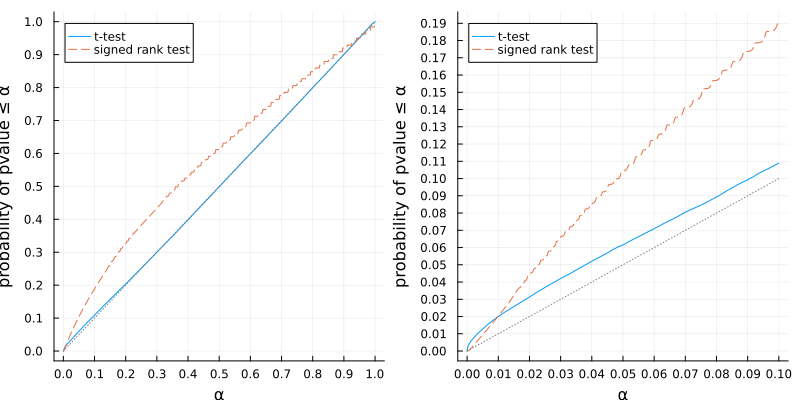

In [17]:
using HypothesisTests
using Distributions
using StatsBase: ecdf
using StatsPlots

function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

# light.csv
speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]

@show speed
@show median(speed) mean(speed) var(speed) skewness(speed) kurtosis(speed)
@show pvalue_tdist(speed, 990)
@show pvalue(SignedRankTest(speed .- 990))

pval_t, pval_w = let L = 10^5, c = 0, n = length(speed)
    pval_t = Vector{Float64}(undef, L)
    pval_w = Vector{Float64}(undef, L)
    for i in 1:L
        X = sample(speed, n)
        pval_t[i] = pvalue_tdist(X, mean(speed))
        pval_w[i] = pvalue(SignedRankTest(X .- median(speed)))
    end
    pval_t, pval_w
end
_ecdf_pval_t = ecdf(pval_t)
_ecdf_pval_w = ecdf(pval_w)
ecdf_pval_t(x) = _ecdf_pval_t(x)
ecdf_pval_w(x) = _ecdf_pval_w(x)

P1 = plot(ecdf_pval_t, 0, 1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

P2 = plot(ecdf_pval_t, 0, 0.1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

plot(P1, P2; size=(800, 400))

speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]
median(speed) = 940.0
mean(speed) = 909.0
var(speed) = 11009.473684210527
skewness(speed) = -0.8906989686637442
kurtosis(speed) = 0.15387338159088726
pvalue_tdist(speed, 990) = 0.0026685840985367784
pvalue(SignedRankTest(speed .- 990)) = 0.0021301280771450506


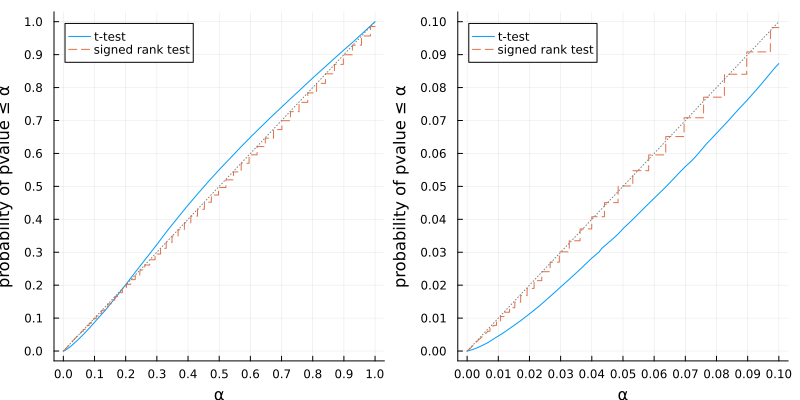

In [18]:
using HypothesisTests
using Distributions
using StatsBase: ecdf
using StatsPlots

function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

# light.csv
speed = [850, 740, 900, 1070, 930, 850, 950, 980, 980, 880, 1000, 980, 930, 650, 760, 810, 1000, 1000, 960, 960]

@show speed
@show median(speed) mean(speed) var(speed) skewness(speed) kurtosis(speed)
@show pvalue_tdist(speed, 990)
@show pvalue(SignedRankTest(speed .- 990))

pval_t, pval_w = let L = 10^5, c = 0, n = length(speed)
    pval_t = Vector{Float64}(undef, L)
    pval_w = Vector{Float64}(undef, L)
    for i in 1:L
        X = rand(TDist(2), n)
        pval_t[i] = pvalue_tdist(X, 0)
        pval_w[i] = pvalue(SignedRankTest(X))
    end
    pval_t, pval_w
end
_ecdf_pval_t = ecdf(pval_t)
_ecdf_pval_w = ecdf(pval_w)
ecdf_pval_t(x) = _ecdf_pval_t(x)
ecdf_pval_w(x) = _ecdf_pval_w(x)

P1 = plot(ecdf_pval_t, 0, 1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

P2 = plot(ecdf_pval_t, 0, 0.1; label="t-test")
plot!(ecdf_pval_w; label="signed rank test", ls=:dash)
plot!(identity; label="", ls=:dot, c=:grey)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(xguide="α", yguide="probability of pvalue ≤ α")

plot(P1, P2; size=(800, 400))